In [1]:
import numpy as np
%matplotlib notebook
import pylab as plt
import pickle as pickle

import networkx as nx

from NAQ_graphs import NAQ

#for automatic graph generation
import yaml as yaml
from graph_generator import generate_graph
import os as os

/home/arnaudon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


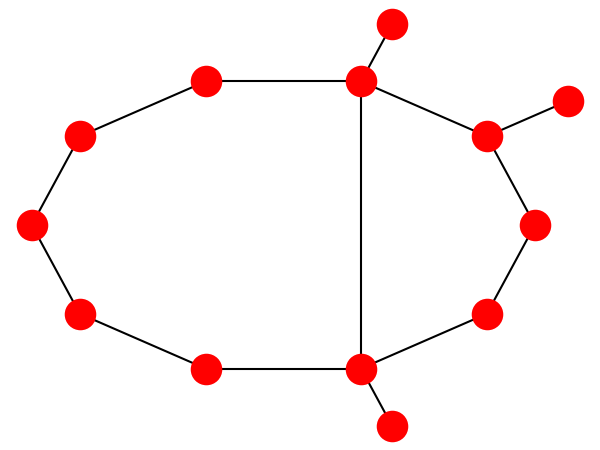

/home/arnaudon/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [2]:
#create a small world network, using automatic generation, see generate_graph and graph_params for more

graph_tpe = 'SM'
params = yaml.load(open('graph_params.yaml','rb'))[graph_tpe]

G, pos  = generate_graph(tpe=graph_tpe, params = params)

if not os.path.isdir(graph_tpe):
    os.mkdir(graph_tpe)
os.chdir(graph_tpe)

#plot the graph
plt.figure(figsize=(4,3))
nx.draw(G, pos=pos, node_size=200)

In [3]:
#setup the main object
chi = np.array([ 1.j for i in range(len(G.edges))])

naq_u1 = NAQ(G, positions = pos, tot_len = 10, chi = chi, group = 'U1', open_graph = True)

naq_u1.n_processes_scan = 4 #number of CPU to use

#random update
naq_u1.update_chi([1.,1.])

#construct the graph laplacian
naq_u1.update_laplacian()

Total lenght: 10
Average lenght: 0.9090909090909091


In [4]:
#load the modes found in test_NAQ_U1_open.ipynb
modes = pickle.load(open('modes.pkl', 'rb'))
Ks, Alphas, s = pickle.load( open('scan.pkl', 'rb'))

<IPython.core.display.Javascript object>


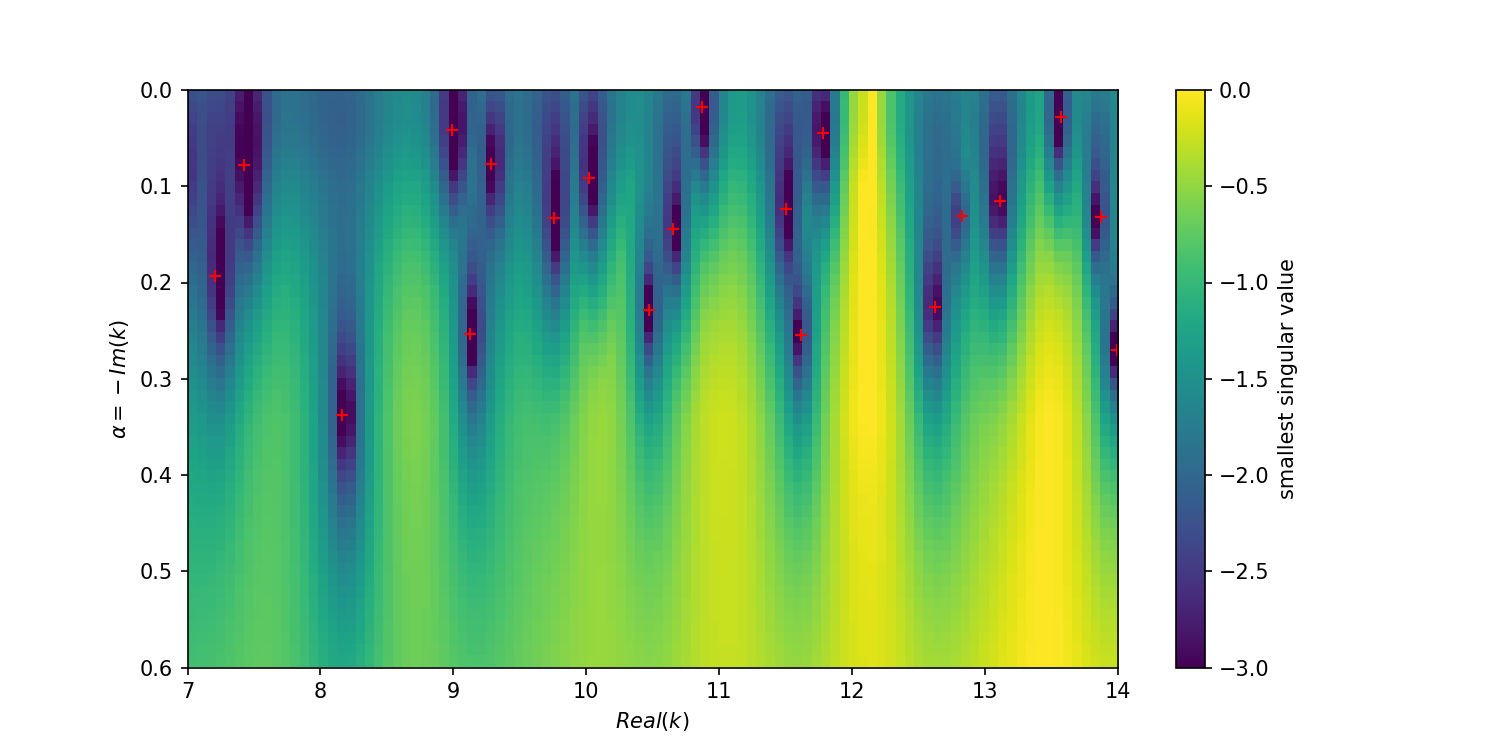

In [5]:
#plot the scan and modes
naq_u1.plot_scan(Ks,Alphas,s,modes)


In [371]:
#pump parameters (see SALT papers)
naq_u1.pump_params = {}
naq_u1.pump_params['gamma_perp'] = 2.
naq_u1.pump_params['k_a']        = 10.
naq_u1.pump_params['D0']         = 0 
naq_u1.pump_params['edges']      = [8,9]  #edges to pump

m = 0
naq_u1.update_chi(modes[m])
print("condition number no pump:", naq_u1.test_laplacian())

naq_u1.pump_params['D0']         = 0
naq_u1.update_chi(modes[m])
print("condition number with pump:", naq_u1.test_laplacian())


condition number no pump: 0.0009343976
condition number with pump: 0.0009343976


In [374]:
def Dinvs():
    D_invs = np.zeros([len(modes),len(G.edges)])
    
    for m in range(len(modes)): 
        for e in range(len(G.edges)):
            naq_u1.pump_params['edges'] = [e,]  #edges to pump

            D_invs[m,e] = 1/naq_u1.linear_lasing_threshold(modes[m], 0)
    return D_invs
D_invs = Dinvs()

<IPython.core.display.Javascript object>


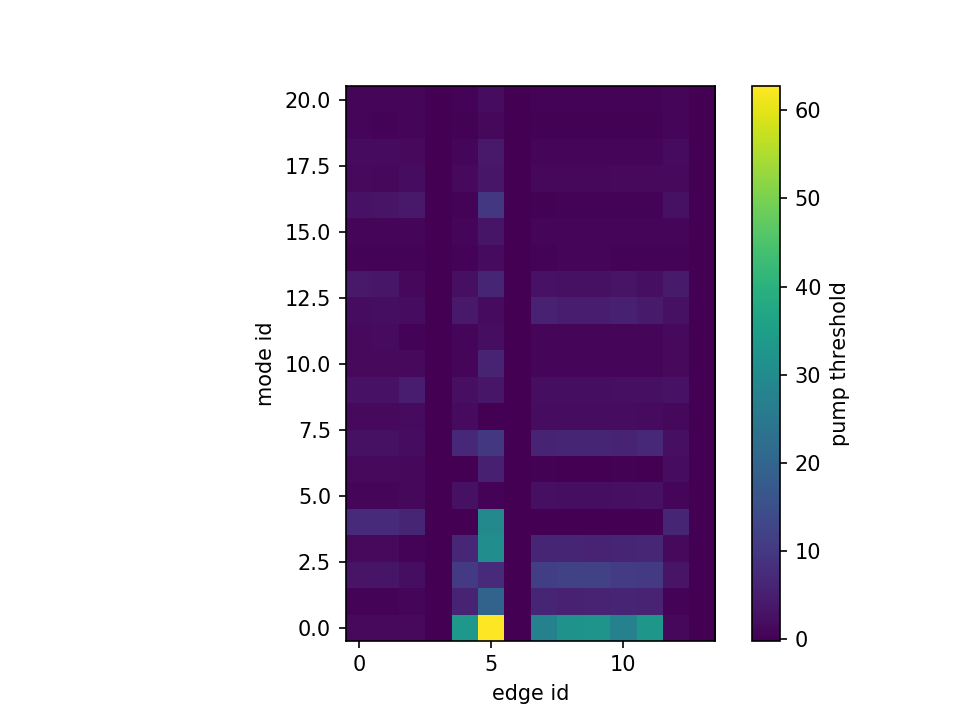

21


Text(0, 0.5, 'mode id')

In [375]:
plt.figure()
print(len(modes))
plt.imshow(D_invs, origin = 'auto')
plt.colorbar(label="pump threshold")
plt.xlabel('edge id')
plt.ylabel('mode id')


In [383]:
mode_0 = 2

def find_list_edges(mode_0):
    best_e = []
    for e in range(len(G.edges)):
        if e in naq_u1.in_mask_list:# and D_invs[mode_0,e]>0:
            De = []
            for m in range(len(modes)): 
                if m is not mode_0:
                    De.append(D_invs[mode_0,e]-D_invs[m,e])
    
            best_e.append(np.min(De))
        else:
            best_e.append(-100)
            
    #print(np.sort(best_e)[::-1])
    return np.argsort(best_e)[::-1]

edge_id = find_list_edges(mode_0)

print(D_invs[mode_0, edge_id])

D_th = 1./(D_invs[mode_0,edge_id[:5]]).sum()

print(D_th)

[ 3.04140529  3.25389908  3.13251974  1.99366213 11.41716859 11.0367673
 12.29877115 12.0893044  10.45777939 10.55472061  7.43968748  0.
  0.          0.        ]
0.04378541588487953


In [385]:
#cost(out.x)
naq_u1.pump_params['edges'] = edge_id[:5]
print(naq_u1.pump_params['edges'])

[12  1  0  2  7]


<IPython.core.display.Javascript object>


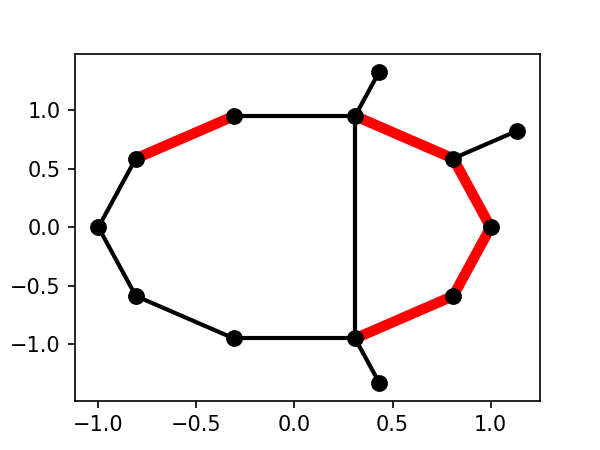

In [386]:
#plot the graph with the pump
plt.figure(figsize=(4,3))
#nx.draw(G, pos=pos, node_size=200)
nodes = nx.draw_networkx_nodes(G,pos=pos, node_color = 'k', node_size=50)# np.abs(phi)**2, cmap='plasma')
edges = nx.draw_networkx_edges(G,pos=pos, edge_color = 'k', width=2)

#get the edge list for the pump
edge_pump = []
for k, e in enumerate(G.edges):
    if k in naq_u1.pump_params['edges']:
        edge_pump.append(e)

edges_pump = nx.draw_networkx_edges(G,pos=pos, edgelist = edge_pump, edge_color = 'r', width=5)

plt.savefig('pump_shape.png')


In [387]:
#find the pump trajectories
params['s_size']    = 1e-3*np.asarray([1.,1.])

#the correct balaance between s_size and the D0 steps must be found for each graph/pump
D0_max = .05
D0_steps = 10

new_modes = naq_u1.pump_trajectories(modes, params, D0_max = D0_max, D0_steps = D0_steps)














  0%|          | 0/9 [00:00<?, ?it/s]












 11%|█         | 1/9 [00:09<01:18,  9.85s/it]












 22%|██▏       | 2/9 [00:20<01:10, 10.12s/it]












 33%|███▎      | 3/9 [00:37<01:13, 12.17s/it]












 44%|████▍     | 4/9 [00:51<01:02, 12.58s/it]












 56%|█████▌    | 5/9 [01:02<00:48, 12.14s/it]












 67%|██████▋   | 6/9 [01:12<00:35, 11.68s/it]












 78%|███████▊  | 7/9 [01:21<00:21, 10.88s/it]












 89%|████████▉ | 8/9 [01:31<00:10, 10.41s/it]












100%|██████████| 9/9 [01:40<00:00, 10.17s/it]

In [388]:

def plot_pump_traj(self, Ks, Alphas, s, modes, new_modes, estimate = False):
        self.plot_scan(Ks,Alphas,s, modes)

        if modes is not None:
            plt.plot(modes[:,0], modes[:,1],'ro')

        for i in range(len(modes)):
            D_th = self.linear_lasing_threshold(modes[i], self.D0s[0])
            
            #if D_th < self.D0s[-1] and D_th>0:
            #    plt.plot(new_modes[:,i,0],new_modes[:,i,1],'r-.')
            #else:
            plt.scatter(new_modes[:,i,0],new_modes[:,i,1],s=20,c='k')

        #plt.plot(new_modes[-1,:,0],new_modes[-1,:,1],'k+')

        ax = plt.gca()
        for i in range(len(modes)):
            dx = new_modes[-1,i,0]-new_modes[-2,i,0]
            dy = new_modes[-1,i,1]-new_modes[-2,i,1]

            #plt.arrow(new_modes[-1,i,0], new_modes[-1,i,1], dx, dy, head_width=0.005, head_length=0.01, fc='k', ec='k')
            ax.annotate("", xy=(new_modes[-1,i,0], new_modes[-1,i,1]), xytext=(new_modes[-2,i,0], new_modes[-2,i,1]), arrowprops=dict(facecolor='black', shrink=0.05))


        if estimate:
            for m in range(len(modes)):

                for iD0 in range(len(self.D0s)-1):
                    D_th = self.linear_lasing_threshold(new_modes[iD0][m], self.D0s[iD0])

                    k_shift = self.pump_linear(new_modes[iD0][m], self.D0s[iD0], self.D0s[iD0+1])
                    
                    if D_th < self.D0s[-1]-self.D0s[iD0] and D_th>0:
                        plt.scatter(new_modes[iD0][m][0]+np.real(k_shift), new_modes[iD0][m][1]- np.imag(k_shift), s=10, c='b')
                    else:
                        plt.scatter(new_modes[iD0][m][0]+np.real(k_shift), new_modes[iD0][m][1]- np.imag(k_shift), s=10, c='b')

                    plt.plot([new_modes[iD0][m][0], new_modes[iD0][m][0]+np.real(k_shift)], [new_modes[iD0][m][1], new_modes[iD0][m][1] - np.imag(k_shift)], c='k', lw = 0.8)
                    

2


<IPython.core.display.Javascript object>


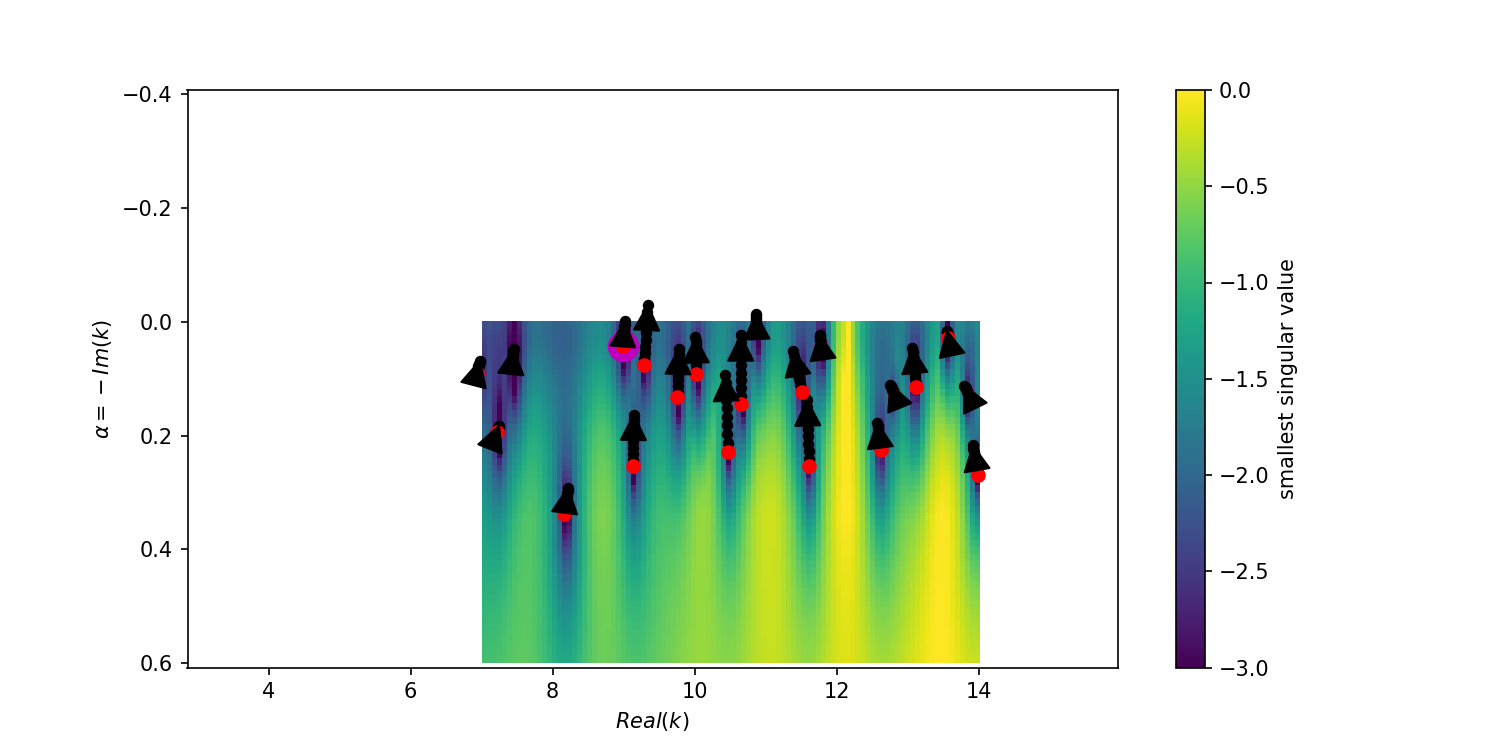

In [389]:
#plot the pump trajectories
print(mode_0)
plot_pump_traj(naq_u1, Ks, Alphas, s, modes, new_modes, estimate=False)
plt.scatter(modes[mode_0,0], modes[mode_0,1], s=200, c='m')

In [44]:
params['s_size']    = 1e-2*np.asarray([1.,1.])
params['max_steps'] = 2000
                        
th_modes, D0_th = naq_u1.full_lasing_threshold(modes, params, tol = 1e-4, D0_max = D0_max, D0_steps = D0_steps)

  0%|          | 0/16 [00:00<?, ?it/s]

Start running many attempts (threshold search)
1 attempts to find a mode, think of fine tuning parameters! (threshold search)


100%|██████████| 16/16 [00:24<00:00,  1.50s/it]


<IPython.core.display.Javascript object>


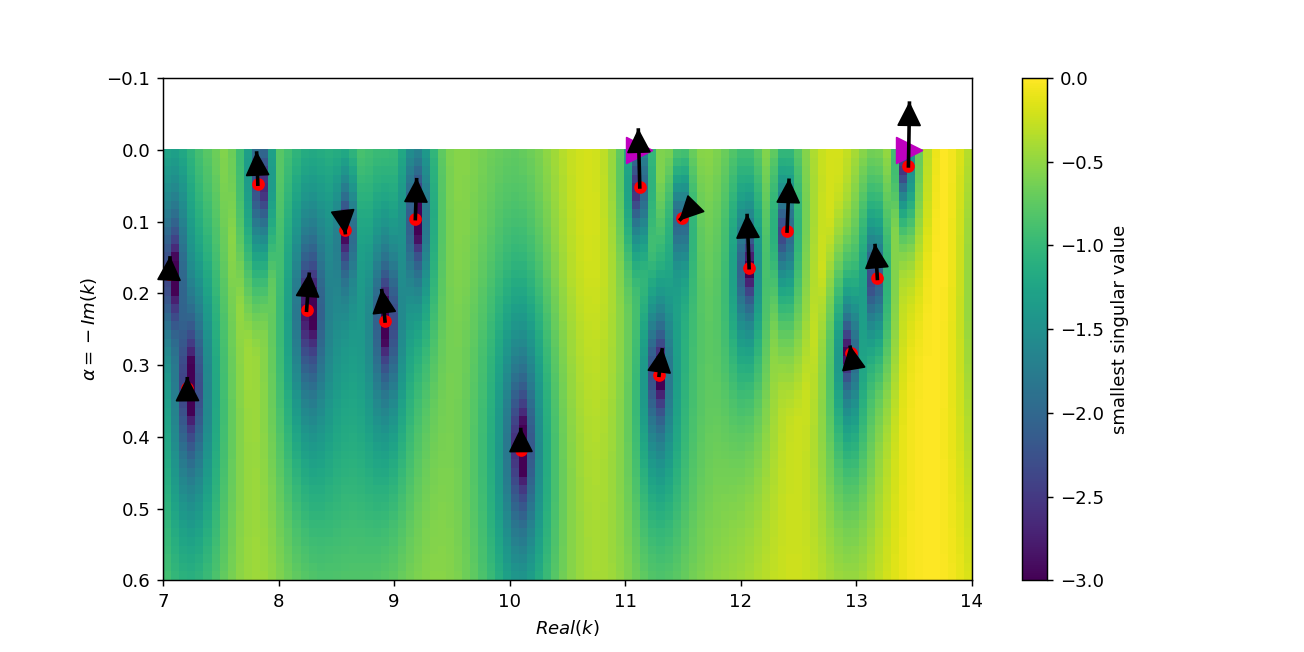

In [45]:
#plot the trajectories and the lasing modes

naq_u1.plot_pump_traj(  Ks, Alphas, s, modes, new_modes, estimate=False)
plt.axis([Ks[0], Ks[-1], Alphas[-1], -0.1])

for m in th_modes:
    if type(m) == np.ndarray:
        plt.scatter(m[0], m[1], marker = '>', s= 200, c='m')
#plt.axis([13.3, 13.5, 0.03, -0.01])
plt.show()

pickle.dump([th_modes, D0_th], open('threshold_modes.pkl', 'wb')) #save it for later

In [46]:
#create a smaller list of possible lasing modes out of all the passive modes 
# (remove the ones with -1 from the search above)

th_modes_selec = []
D0_th_selec = []
for i, m in enumerate(th_modes):
    if type(m) == np.ndarray:
        th_modes_selec.append(m)
        D0_th_selec.append(D0_th[i])
        
th_modes_selec = np.asarray(th_modes_selec)
D0_th_selec = np.asarray(D0_th_selec)
print(th_modes_selec)
print(D0_th_selec)

[[ 1.34544994e+01  1.26259495e-06]
 [ 1.11186108e+01 -1.87726687e-06]]
[0.01300995 0.03279286]


k= (13.45449943932379-1.2625949453336422e-06j)


<IPython.core.display.Javascript object>


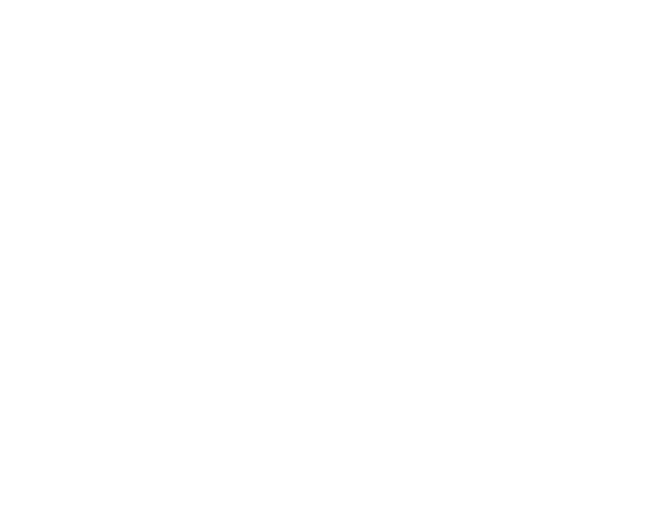

k= (11.118610774920773+1.8772668711095845e-06j)


<IPython.core.display.Javascript object>


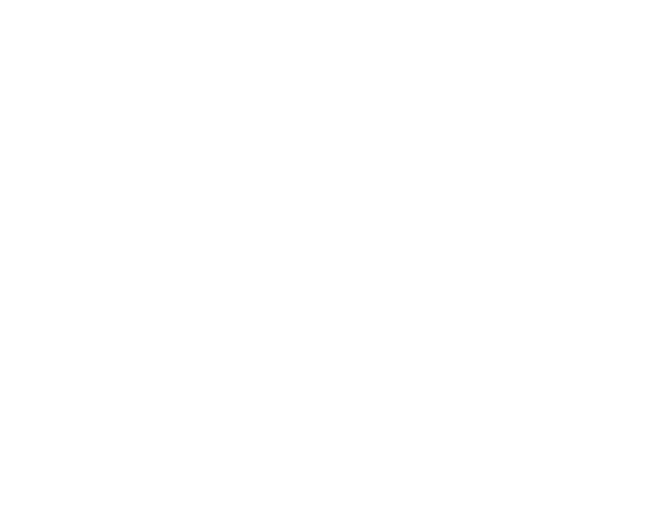

In [47]:

#for each mode, save a figure for it
if not os.path.isdir('lasing_modes'):
    os.mkdir('lasing_modes')

for m in range(len(th_modes_selec)):
    print("k=", th_modes_selec[m,0]-1j*th_modes_selec[m,1])
    naq_u1.pump_params['D0'] = D0_th_selec[m]
                
    naq_u1.update_chi(th_modes_selec[m])
    naq_u1.update_laplacian()
    phi = naq_u1.compute_solution()
    edge_color = naq_u1.compute_edge_mean_E2()

    plt.figure(figsize=(5,4))
    nodes = nx.draw_networkx_nodes(naq_u1.graph, pos=naq_u1.pos, node_color = 'k', node_size=10)# np.abs(phi)**2, cmap='plasma')
    edges_k = nx.draw_networkx_edges(naq_u1.graph, pos=naq_u1.pos, edge_color = 'k', width=2)

    #plot the edge with large field last (or on top)
    order_edges = np.argsort(edge_color)
    for i in order_edges:
        for ei, e in enumerate(naq_u1.graph.edges):
            if ei == i:
                edges = nx.draw_networkx_edges(naq_u1.graph, pos=naq_u1.pos, edgelist = [e,], edge_color = [edge_color[i],], edge_cmap=plt.get_cmap('Greens'), width=8, alpha=0.7, edge_vmin=0, edge_vmax = np.max(edge_color))
    
    #plt.colorbar(nodes, label=r'Node $|E_i|^2$')
    plt.colorbar(edges, label=r'Edges $\frac{1}{l_{ij}}\int_0^{l_{ij}}|E_{ij}(x)|^2 dx$')

    plt.title("k="+str(np.around(th_modes_selec[m,0],2)-1j*np.around(th_modes_selec[m,1],3)))
    plt.axis('off')
    plt.savefig('lasing_modes/mode_'+str(m)+'.svg')
    plt.close()


In [307]:
def compute_E2(self):
        """
        Compute the norm \int|E|^2 on each edge for normalisation later
        """
        
        phi = self.compute_solution()
        flux = self.Winv.dot(self.BT.T).dot(phi) #we use BT.T as we need to make sure the the in-fluxes vanish
        
        edge_mean = np.zeros(self.m)
        for ei, e in enumerate(list(self.graph.edges())):
            (u, v) = e[:2]
            if len(self.graph[u])>1 and len(self.graph[v])>1:

                z = np.zeros([2,2])
                if abs(np.real(self.graph[u][v]['chi']))>0: #if k has a complex part (recall \chi = ik)
                    z[0, 0] = 1.
                else: #we recast to real because it is real
                    z[0, 0] = np.real((np.exp( self.graph[u][v]['L']*(self.graph[u][v]['chi'] + np.conj(self.graph[u][v]['chi'])) ) - 1.)/self.graph[u][v]['L']*(self.graph[u][v]['chi'] + np.conj(self.graph[u][v]['chi'])) )

                #no issue here if im(k)=0, and just recast to real 
                z[0, 1] =  np.real(( np.exp( self.graph[u][v]['L']*self.graph[u][v]['chi'] ) - np.exp( self.graph[u][v]['L']*np.conj(self.graph[u][v]['chi'])) ) / (self.graph[u][v]['L']*( self.graph[u][v]['chi'] - np.conj(self.graph[u][v]['chi']) ) ))
            
                #other matrix elements
                z[1, 0] = z[0, 1]
                z[1, 1] = z[0, 0]
            
                #then compute the norm
                edge_mean[ei] = self.graph[u][v]['L']*np.real(np.conj(flux[2*ei:2*ei+2]).T.dot(z.dot(flux[2*ei:2*ei+2]))) #BUG flux est du mauvais type je crois, type(flux[2*ei:2*ei+2]): <class 'scipy.sparse.csc.csc_matrix'>
        
        #return the sqrt of the norm, i.e. \sqrt{ \int |E|^2 dx}
        return np.sqrt(edge_mean.sum())

In [363]:
def T_matrix(self, th_modes, D0_th, phase= 0 ):
            """
            Compute the T_{\mu\nu} matrix for nonlinear SALT
            """

            #first extract the flux vectors and Gammas
            fluxes = []
            gammas = []
            pump_norms = [] #collect the \int \delta_I E^2 for later
            n_modes = len(D0_th) #number of modes
            for i in range(n_modes):
                
                self.pump_params['D0'] = D0_th[i]
                
                self.update_chi(th_modes[i])
                self.update_laplacian()
                phi = self.compute_solution()
    
                #normalize the modes first
                L0_in_norm = compute_E2(naq_u1)
                #phi /= L0_in_norm
                
                #compute the pump norm
                self.Z_matrix_U1() #compute the Z matrix
                edge_norm = self.Winv.dot(self.Z).dot(self.Winv) #compute the correct weight matrix
                L0_pump = self.BT.dot(edge_norm.dot(self.pump_mask)).dot(self.B).asformat('csc')
                L0_pump_norm = phi.T.dot(L0_pump.dot(phi))
                
                #phi /= np.sqrt(L0_pump_norm)
                
                pump_norms.append(L0_pump_norm)
                
                #compute the edge solution with correct normalisation
                flux = self.Winv.dot(self.BT.T).dot(phi)
                if i ==0:
                    flux *= np.exp(.19j)
                if i ==1:
                    flux *= np.exp(2.88j)
                fluxes.append(flux)
                gammas.append(self.gamma)
                
            #populate the matrix, entry by entry (not a symmetric matrix!)
            T = np.zeros([n_modes, n_modes], dtype=np.complex64)
            for mu in range(n_modes):
                for nu in range(n_modes):
                    
                    #first set shorthand notations (following the notes)
                    lamb_mu = fluxes[mu]
                    lamb_nu = fluxes[nu]
                    
                    k_mu = (th_modes[mu][0]-1.j*th_modes[mu][1])*np.sqrt(1. + gammas[mu] * D0_th[mu])
                    k_nu = (th_modes[nu][0]-1.j*th_modes[nu][1])*np.sqrt(1. + gammas[nu] * D0_th[nu]) 
                    
                    Delta = k_nu - np.conj(k_nu)
                    Lamb  = k_nu + np.conj(k_nu)
                    
                    #compute the matrix element looping only on the pumped edges
                    for ei, e in enumerate(list(self.graph.edges())):
                        if ei in self.pump_params['edges']:
                            (u, v) = e[:2]

                            #shortand notation (as in the notes)
                            lamb_nu_plus = lamb_nu[2*ei]
                            lamb_nu_minus = lamb_nu[2*ei+1]
                            lamb_mu_plus = lamb_mu[2*ei]
                            lamb_mu_minus = lamb_mu[2*ei+1]
                            l = self.graph[u][v]['L']
                            
                            exp_term_1 = ( np.exp(1.j*(2*k_mu+Delta)*l) - 1. ) / (1.j*(2*k_mu+Delta))

                            T[mu, nu] += exp_term_1 * ( abs(lamb_nu_plus)**2*lamb_mu_plus**2  + 
                                                        abs(lamb_nu_minus)**2*lamb_mu_minus**2
                                                       )
                            
                            exp_term_2 = ( np.exp(2.j*k_mu*l) - np.exp(1.j*Delta*l) ) / (1.j*(2*k_mu-Delta))

                            T[mu, nu] += exp_term_2 * ( abs(lamb_nu_plus)**2*lamb_mu_minus**2 +
                                                        abs(lamb_nu_minus)**2*lamb_mu_plus**2 
                                                       )
                            
                            exp_term_3 = np.exp(1.j*k_mu*l)*(np.exp(1.j*Delta*l) - 1.) / (1.j*Delta) 
                            
                            T[mu, nu] += 2*exp_term_3 * ( abs(lamb_nu_plus)**2*lamb_mu_plus*lamb_mu_minus +
                                                          abs(lamb_nu_minus)**2*lamb_mu_plus*lamb_mu_minus
                                                        )
                            
                            exp_term_4 = ( np.exp(1.j*(2.*k_mu+k_nu)*l) 
                                          - np.exp(-1.j*np.conj(k_nu)*l) ) / (1.j*(2*k_nu+Lamb))
                            
                            T[mu, nu] += exp_term_4 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_plus**2 +
                                                        np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_minus**2
                                                      )
                            
                            exp_term_5 = ( np.exp(1.j*(2.*k_mu-np.conj(k_nu))*l) 
                                          - np.exp(1.j*k_nu*l) ) / (1.j*(2*k_nu-Lamb))
                            
                            T[mu, nu] += exp_term_5 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_minus**2 +
                                                       np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_plus**2
                                                      )
                        
                            exp_term_6 =   np.exp(1.j*k_mu*l) * ( np.exp(1.j*k_nu*l) 
                                                - np.exp(-1.j*np.conj(k_nu)*l) ) / (1.j*Lamb)
                                
                            T[mu, nu] += 2*exp_term_6 * ( lamb_nu_plus*np.conj(lamb_nu_minus)*lamb_mu_minus*lamb_mu_plus +
                                                        np.conj(lamb_nu_plus)*lamb_nu_minus*lamb_mu_minus*lamb_mu_plus
                                                      )
                    T[mu, nu] /= pump_norms[mu] #divide by the other integral \int \delta_i E^2
                    T[mu, nu] *= np.imag(-gammas[nu]) #finally multiply by \Gamma_\nu and use only the real part of T
            #print((T))
            #T = 0*np.real(T)+.22#/len(T)
            #T += np.diag(0.15*np.ones(len(T)))
            #if len(T)>1:
            #    T[1,0] = 0.01
            
            #T[0,0] = 0.8
            #T *= 0.1
            #T += 4*np.diag(np.diag(T))
            #if len(T)>1:
            #    T[0,1] = .1
            #    T[1,0] = 0.05
            return np.real(T.T) #convert it to a array with real numbers
phase =-0.1                          
T = T_matrix(naq_u1, th_modes_selec, D0_th_selec, phase)
print(T)
print(np.linalg.inv(T))

[[0.22457048 0.35965854]
 [0.19298685 0.18402372]]
[[-6.552835  12.8069515]
 [ 6.8719993 -7.9966497]]


<IPython.core.display.Javascript object>


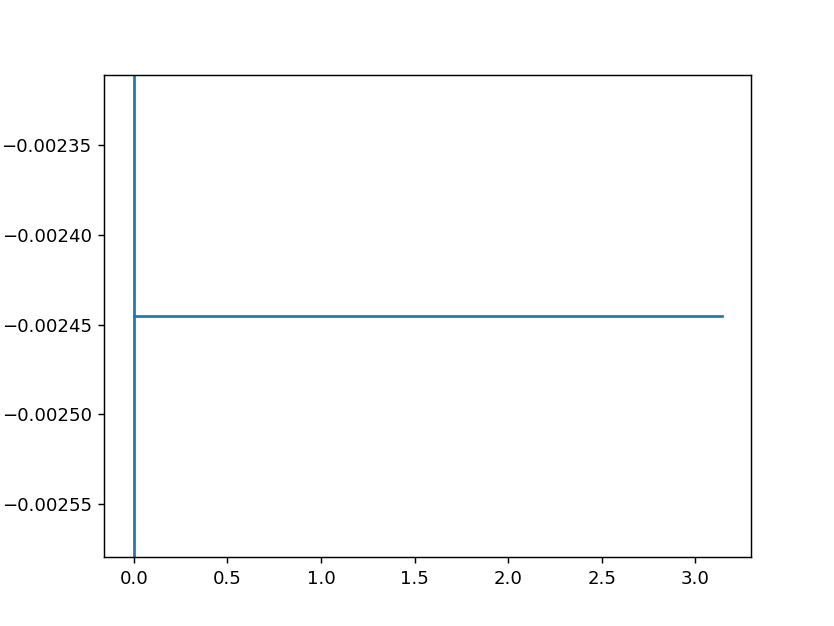

0.0


In [358]:
Ph = np.linspace(0,np.pi, 100)
norm = []
for phase in Ph:
    norm.append(np.imag(T_matrix(naq_u1, th_modes_selec, D0_th_selec, phase))[0,1])
plt.figure()
plt.plot(Ph, norm)
plt.axvline(Ph[np.argmin(np.abs(norm))])
print(Ph[np.argmin(np.abs(norm))])

In [364]:
def modal_intensities(self, D0_max, D0_steps, th_modes, D0_th):
    """
    compute the modal intensities of the modes up to D0, with D0_steps
    """
    D0_th = np.array(D0_th)
    th_modes = np.array(th_modes)
    
    n_modes = len(D0_th)
    
    D0s = np.linspace(0, D0_max, D0_steps)
    
    D0_th_min = np.min(D0_th) #smallest lasing threshold
    th_mode_first = th_modes[np.argmin(D0_th)] #first lasing mode
    
    D0_th_inv = 1./D0_th #inverse of lasing thresholds
    
    I = np.zeros([n_modes, D0_steps]) #collect the modal intensities
    lasing_modes = [] #ordered list of lasing modes ids
    
    next_D0 = D0_th_min #set the next lasing threshold to the minimum one 
    next_lasing_mode  = np.argmin(D0_th) #set the next lasing mode as the first to possibly lase
      
    for i, D0 in enumerate(D0s):
        print('D0', D0, 'next', next_D0)
        if D0 > D0_th_min: #before the first mode lases, nothing happens
            
            #while we can add new lasing modes, add them 
            search_new_lasing_modes = True 
            while search_new_lasing_modes:

                if D0 > next_D0: #if the next mode can be lased, add it and search the next one
                    lasing_modes += [next_lasing_mode,]
                    print('lasing modes', lasing_modes)


                    #if needed, compute all the interacting thresholds for the non-lasing modes
                    D0_ints = np.ones(n_modes)*1e5 #to collect the interacting thresholds, set them to large for later search of smallest
                    for mu in range(n_modes):
                        if mu not in lasing_modes:

                            #first compute the larger T matrix (including the mode m)
                            T_mu = T_matrix(self, th_modes[lasing_modes + [mu,]], D0_th_selec[lasing_modes + [mu,]])
                            T_mu_inv = np.linalg.inv(T_mu)

                            #compute the interacting threshold of mode m
                            D0_ints[mu] = 1./ ( T_mu_inv[-1].dot(D0_th_inv[lasing_modes + [mu,]]) / T_mu_inv[-1].dot( np.ones(len(lasing_modes)+1)) )
                            
                            D0_ints[mu] = np.real(D0_ints[mu])
                            
                    print(D0_ints, D0)
                    #next interacting threshold
                    next_D0 = np.min(np.real(D0_ints) )
                    next_lasing_mode = np.argmin(D0_ints)

                else: #if the next mode does not lase, stop the search and compute the modal intensities
                    search_new_lasing_modes = False
                    
            #update the T^{-1} matrix with new the new mode
            T_inv = np.linalg.inv(T_matrix(self, th_modes[lasing_modes], D0_th_selec[lasing_modes]))
            #print(T_matrix(self, th_modes[lasing_modes], D0_th_selec[lasing_modes]))
            #print(T_inv)
            #compute the modal intensities
            I[lasing_modes, i] = ( D0*T_inv.dot(D0_th_inv[lasing_modes]) - T_inv.sum(1) )
            #print(T_inv.dot(D0_th_inv[lasing_modes]),T_inv )
    return I

D0_steps = 100
D0_max = .05

I = modal_intensities(naq_u1, D0_max, D0_steps, th_modes_selec, D0_th_selec)

D0 0.0 next 0.013009951678730529
D0 0.000505050505050505 next 0.013009951678730529
D0 0.00101010101010101 next 0.013009951678730529
D0 0.0015151515151515152 next 0.013009951678730529
D0 0.00202020202020202 next 0.013009951678730529
D0 0.002525252525252525 next 0.013009951678730529
D0 0.0030303030303030303 next 0.013009951678730529
D0 0.0035353535353535356 next 0.013009951678730529
D0 0.00404040404040404 next 0.013009951678730529
D0 0.004545454545454545 next 0.013009951678730529
D0 0.00505050505050505 next 0.013009951678730529
D0 0.005555555555555556 next 0.013009951678730529
D0 0.006060606060606061 next 0.013009951678730529
D0 0.0065656565656565654 next 0.013009951678730529
D0 0.007070707070707071 next 0.013009951678730529
D0 0.007575757575757576 next 0.013009951678730529
D0 0.00808080808080808 next 0.013009951678730529
D0 0.008585858585858586 next 0.013009951678730529
D0 0.00909090909090909 next 0.013009951678730529
D0 0.009595959595959595 next 0.013009951678730529
D0 0.01010101010101

<IPython.core.display.Javascript object>


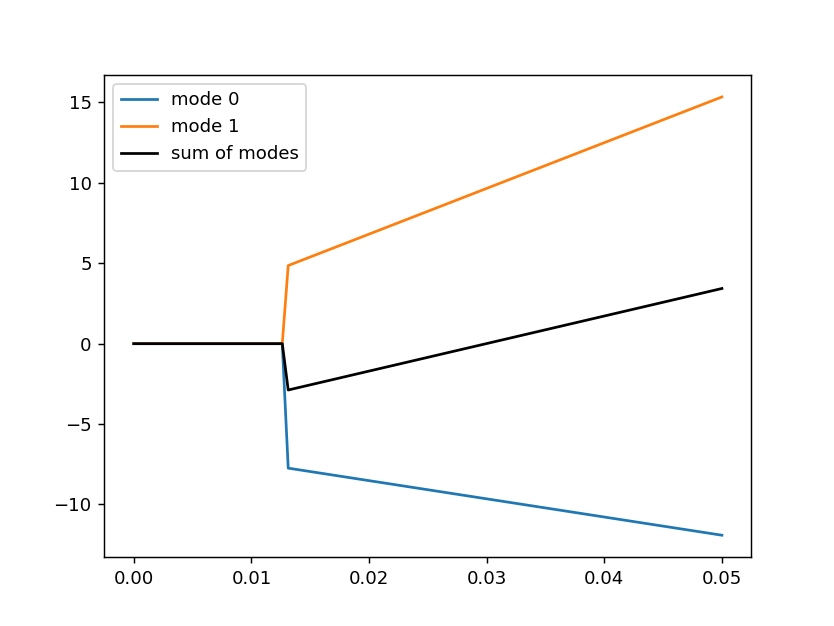

In [365]:
plt.figure()
D0s = np.linspace(0, D0_max, D0_steps)

for i in range(len(I)):
    plt.plot(D0s, (I[i]), '-', label='mode '+str(i))
    
plt.plot(D0s,I.sum(0),'-k',label='sum of modes')
plt.legend(loc='best')